In [132]:
import numpy as np

from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd

In [15]:
#load dataframe from csv
demographics_data = pd.read_csv("data/zip/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
del demographics_data["Geo_ZCTA5"]
del demographics_data["Geo_ZCTA3"]
del demographics_data["Geo_LOGRECNO"]
del demographics_data["Geo_GEOCOMP"]
del demographics_data["Geo_SUMLEV"]
print(demographics_data.shape)

(33120, 2151)
(33120, 2146)


In [17]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [168]:
#reduced_demos = demographics_data[["SE_A00002_002", "SE_A10003_001", "SE_B12001_002", "SE_B12001_003", "SE_B12001_004", "SE_A14002_002", "SE_A14002_003", "SE_A14002_004", "SE_A14002_005", "SE_A14002_006", "SE_A14002_007", "SE_A14002_008", "SE_A14002_009", "SE_A14002_010", "SE_A14002_011", "SE_A14002_012", "SE_A14028_001", "SE_A10035B_002", "SE_A10035B_003", "SE_A10035B_004", "SE_A10035B_005", "SE_A10035B_006", "SE_A10035B_007", "SE_A10035B_008", "SE_A10035B_009" ]]
reduced_demos = demographics_data[["SE_A00002_002", "SE_A14028_001", "SE_A14011_001", "SE_A14008_001", "SE_B10040_002", "SE_B10040_003"]]

In [169]:
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])

SE_A14028_001     948
SE_A14011_001    1662
SE_A14008_001    1220
SE_B10040_002      35
SE_B10040_003      35
dtype: int64


In [170]:
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)

(31458, 6)


In [174]:
reduced_demos = StandardScaler().fit_transform(reduced_demos)

In [175]:
reduced_demos[0:5]

array([[-0.20466566,  1.51329765, -1.66533533, -1.6946727 ,  0.12325926,
         0.0965012 ],
       [-0.00593969,  1.21888021, -1.48664864, -1.50961499,  1.17459855,
         1.23072686],
       [ 0.05212103,  2.130997  , -1.39345474, -1.41686336,  1.69966189,
         1.69996235],
       [-0.22797179,  0.90714409, -1.72230962, -1.7694078 , -0.38725267,
        -0.0877385 ],
       [-0.10687836,  0.72096836, -1.42201278, -1.45251301,  0.69440206,
         0.67225027]])

 FOR EPS :  0.01  AND SAMPLES  5
Estimated number of clusters: 0
Estimated number of noise points: 31458
 FOR EPS :  0.1  AND SAMPLES  5
Estimated number of clusters: 112
Estimated number of noise points: 20884
 FOR EPS :  0.5  AND SAMPLES  5
Estimated number of clusters: 26
Estimated number of noise points: 2335
 FOR EPS :  1.0  AND SAMPLES  5
Estimated number of clusters: 3
Estimated number of noise points: 440
 FOR EPS :  2.0  AND SAMPLES  5
Estimated number of clusters: 2
Estimated number of noise points: 67
 FOR EPS :  10.0  AND SAMPLES  5
Estimated number of clusters: 1
Estimated number of noise points: 0
 FOR EPS :  0.01  AND SAMPLES  10
Estimated number of clusters: 0
Estimated number of noise points: 31458
 FOR EPS :  0.1  AND SAMPLES  10
Estimated number of clusters: 28
Estimated number of noise points: 24111
 FOR EPS :  0.5  AND SAMPLES  10
Estimated number of clusters: 5
Estimated number of noise points: 3140
 FOR EPS :  1.0  AND SAMPLES  10
Estimated number of clusters: 2


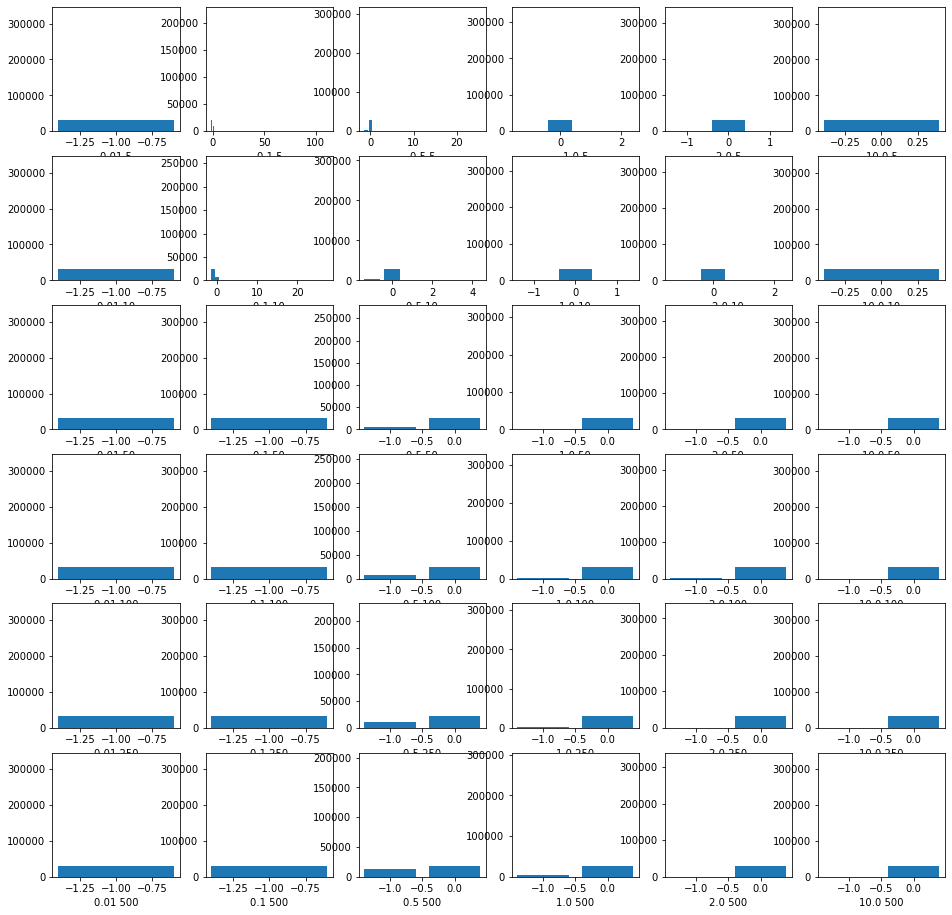

In [177]:
import matplotlib.pyplot as plt

eps = [0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
samples = [5, 10, 50, 100, 250, 500]

fig, axes = plt.subplots(6, 6, figsize = (16, 16))

for i, ax in enumerate(axes.reshape(-1)):
    s = samples[int(i/6)]
    e = eps[int(i % 6)]
    # define the model
    dbscan_model = DBSCAN(eps=e, min_samples=s)

    # train the model
    dbscan_model.fit(reduced_demos)

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(" FOR EPS : ", e, " AND SAMPLES ", s)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    # unique_labels = set(labels)
    # for k in unique_labels:
    #     class_member_mask = (labels == k)
    #     xy = reduced_demos[class_member_mask & core_samples_mask]
    #     print("number of members in cluster ", k, ": ", len(xy))
    #     print(xy.head())

    clusters = np.unique(labels, return_counts=True)
    ax.bar(clusters[0],clusters[1])
    ax.set_xlabel(str(e) + " " + str(s))
    ax.set_ymargin(10)

plt.tightlayout()
plt.show()

In [183]:
dbscan_model_refined = DBSCAN(eps=0.5, min_samples=5)

# train the model
dbscan_model_refined.fit(reduced_demos)

core_samples_mask = np.zeros_like(dbscan_model_refined.labels_, dtype=bool)
core_samples_mask[dbscan_model_refined.core_sample_indices_] = True
labels = dbscan_model_refined.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(" FOR EPS : ", e, " AND SAMPLES ", s)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = reduced_demos[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

 FOR EPS :  10.0  AND SAMPLES  500
Estimated number of clusters: 26
Estimated number of noise points: 2335
number of members in cluster  0 :  28271
number of members in cluster  1 :  5
number of members in cluster  2 :  4
number of members in cluster  3 :  2
number of members in cluster  4 :  2
number of members in cluster  5 :  2
number of members in cluster  6 :  1
number of members in cluster  7 :  3
number of members in cluster  8 :  1
number of members in cluster  9 :  5
number of members in cluster  10 :  2
number of members in cluster  11 :  2
number of members in cluster  12 :  8
number of members in cluster  13 :  2
number of members in cluster  14 :  2
number of members in cluster  15 :  1
number of members in cluster  16 :  1
number of members in cluster  17 :  1
number of members in cluster  18 :  1
number of members in cluster  19 :  1
number of members in cluster  20 :  1
number of members in cluster  21 :  1
number of members in cluster  22 :  3
number of members in clus